In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer

import pickle

%matplotlib inline
plt.style.use("seaborn-deep")


In [2]:
# Import the anime list csv file
anime_list = pd.read_csv("MyAnimeList Dataset/anime_cleaned.csv")

In [3]:
anime_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6668 non-null   int64  
 1   title            6668 non-null   object 
 2   title_english    3438 non-null   object 
 3   title_japanese   6663 non-null   object 
 4   title_synonyms   4481 non-null   object 
 5   image_url        6666 non-null   object 
 6   type             6668 non-null   object 
 7   source           6668 non-null   object 
 8   episodes         6668 non-null   int64  
 9   status           6668 non-null   object 
 10  airing           6668 non-null   bool   
 11  aired_string     6668 non-null   object 
 12  aired            6668 non-null   object 
 13  duration         6668 non-null   object 
 14  rating           6668 non-null   object 
 15  score            6668 non-null   float64
 16  scored_by        6668 non-null   int64  
 17  rank          

In [4]:
# Delete columns with more than 50% null values, as well as all but one title related column
# Save the information into a new variable so the original remains untouched

anime_list_scrubbed = anime_list.drop(["title_english", "title_japanese", "title_synonyms",
                                       "background", "premiered", "broadcast", "licensor"], axis=1)
anime_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6668 non-null   int64  
 1   title            6668 non-null   object 
 2   title_english    3438 non-null   object 
 3   title_japanese   6663 non-null   object 
 4   title_synonyms   4481 non-null   object 
 5   image_url        6666 non-null   object 
 6   type             6668 non-null   object 
 7   source           6668 non-null   object 
 8   episodes         6668 non-null   int64  
 9   status           6668 non-null   object 
 10  airing           6668 non-null   bool   
 11  aired_string     6668 non-null   object 
 12  aired            6668 non-null   object 
 13  duration         6668 non-null   object 
 14  rating           6668 non-null   object 
 15  score            6668 non-null   float64
 16  scored_by        6668 non-null   int64  
 17  rank          

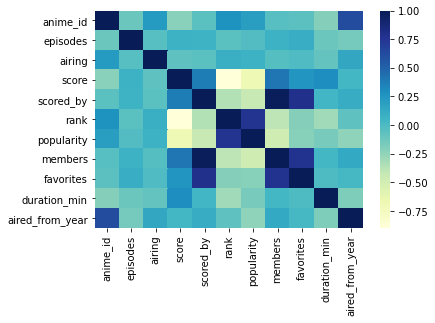

In [5]:
anime_corr_map = sns.heatmap(anime_list.corr(),cmap="YlGnBu")
plt.show()

In [6]:
"""
Though there are still a number of null values, eliminate columns prior to handling the NaN
Columns to drop and reasoning: 
    - members: This correlates almost exactly with "scored_by"
    - favorites: Also correlates over 0.75 with "scored_by"
    - popularity: Correlates strongly to rank. However, popularity tells how many users have show
      on a watch list. Rank and score tell how well the show is viewed based on user scores. Eliminating popularity
    - rank: Strong inverse correlation between rank and score, the higher the score, the lower the rank. Choosing
      to base the model on score rather than rank.
    
"""

anime_list_scrubbed.drop(["members", "favorites", "popularity", "rank"], axis=1, inplace=True )
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6668 non-null   int64  
 1   title            6668 non-null   object 
 2   image_url        6666 non-null   object 
 3   type             6668 non-null   object 
 4   source           6668 non-null   object 
 5   episodes         6668 non-null   int64  
 6   status           6668 non-null   object 
 7   airing           6668 non-null   bool   
 8   aired_string     6668 non-null   object 
 9   aired            6668 non-null   object 
 10  duration         6668 non-null   object 
 11  rating           6668 non-null   object 
 12  score            6668 non-null   float64
 13  scored_by        6668 non-null   int64  
 14  related          6668 non-null   object 
 15  producer         4402 non-null   object 
 16  studio           6668 non-null   object 
 17  genre         

In [7]:
# Remove movies with no genre
anime_list_scrubbed.dropna(subset=["genre"], inplace=True)
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6664 entries, 0 to 6667
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6664 non-null   int64  
 1   title            6664 non-null   object 
 2   image_url        6662 non-null   object 
 3   type             6664 non-null   object 
 4   source           6664 non-null   object 
 5   episodes         6664 non-null   int64  
 6   status           6664 non-null   object 
 7   airing           6664 non-null   bool   
 8   aired_string     6664 non-null   object 
 9   aired            6664 non-null   object 
 10  duration         6664 non-null   object 
 11  rating           6664 non-null   object 
 12  score            6664 non-null   float64
 13  scored_by        6664 non-null   int64  
 14  related          6664 non-null   object 
 15  producer         4401 non-null   object 
 16  studio           6664 non-null   object 
 17  genre         

In [8]:
# Drop producer column, too many are missing, and the ones that have the information often
# have more than one in the cell
# Also drop image_url. It won't be used, and won't provide any assistance with finding similarities
anime_list_scrubbed.drop(["image_url", "producer"], axis=1, inplace=True)

In [9]:
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6664 entries, 0 to 6667
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6664 non-null   int64  
 1   title            6664 non-null   object 
 2   type             6664 non-null   object 
 3   source           6664 non-null   object 
 4   episodes         6664 non-null   int64  
 5   status           6664 non-null   object 
 6   airing           6664 non-null   bool   
 7   aired_string     6664 non-null   object 
 8   aired            6664 non-null   object 
 9   duration         6664 non-null   object 
 10  rating           6664 non-null   object 
 11  score            6664 non-null   float64
 12  scored_by        6664 non-null   int64  
 13  related          6664 non-null   object 
 14  studio           6664 non-null   object 
 15  genre            6664 non-null   object 
 16  opening_theme    6664 non-null   object 
 17  ending_theme  

In [10]:
"""
** Dig into the scored_by column **
    - Check the mean and the standard deviation
    - If necessary, remove any rows that fall below 3 standard deviations
    - Keep the rows above 3 standard deviations. These are likely the most watched shows, we would
      want to recommend them to others if they rate well
"""
average = anime_list_scrubbed["scored_by"].mean()
standard_dev = anime_list_scrubbed["scored_by"].std()

print(f"Mean: {average:.2f}")
print(f"Standard Deviation: {standard_dev:.2f}")

print("Total titles below 3 standard deviations:")
print(anime_list_scrubbed[anime_list_scrubbed["scored_by"] < (average - (standard_dev * 3))]["anime_id"].count()) 
 
print("Total titles above 3 standard deviations:")                                                                                            
print(anime_list_scrubbed[anime_list_scrubbed["scored_by"] >= (average + (standard_dev * 3))]["anime_id"].count())

Mean: 24048.87
Standard Deviation: 61136.74
Total titles below 3 standard deviations:
0
Total titles above 3 standard deviations:
131


<AxesSubplot:>

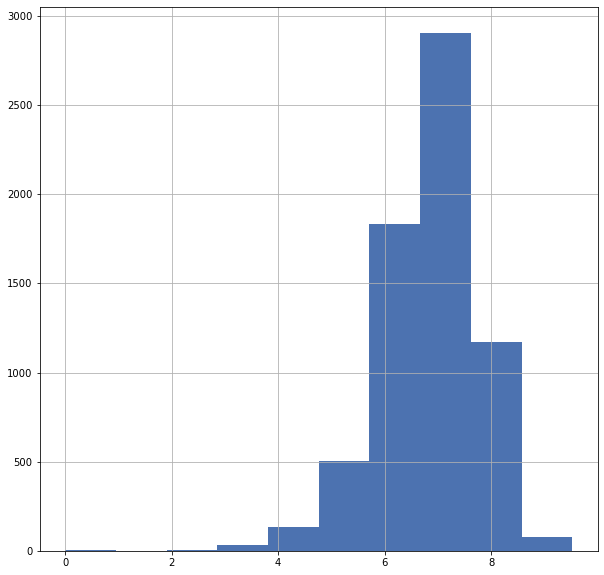

In [11]:
"""
** Dig into the score column **
    - Histogram showing the average score for a show from users.
      As we can see, it's currently significantly skewed to the right.
    - Find the mean and the standard deviation
    - Remove rows with ratings below 3 standard deviations of the mean
    - As above, leave the rows above 3 standard deviations of the mean
"""

# Histogram
anime_list_scrubbed["score"].hist(figsize=(10,10))

In [12]:
# Find the mean and standard deviation
average = anime_list_scrubbed["score"].mean()
standard_dev = anime_list_scrubbed["score"].std()

# Print the mean and standard deviation
print(f"Mean: {average:.2f}")
print(f"Standard Deviation: {standard_dev:.2f}")

# Print outlier counts
print("Total titles below 3 standard deviations:")
print(anime_list_scrubbed[anime_list_scrubbed["score"] < (average - (standard_dev * 3))]["anime_id"].count()) 
 
print("Total titles above 3 standard deviations:")                                                                                            
print(anime_list_scrubbed[anime_list_scrubbed["score"] >= (average + (standard_dev * 3))]["anime_id"].count())


Mean: 6.85
Standard Deviation: 0.93
Total titles below 3 standard deviations:
65
Total titles above 3 standard deviations:
0


<AxesSubplot:>

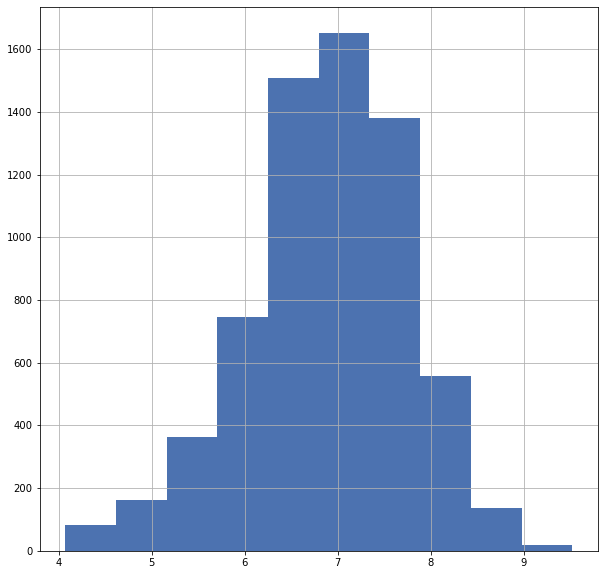

In [13]:
# Drop titles below 3 standard deviations from the mean and reprint the histogram
anime_list_scrubbed = anime_list_scrubbed[anime_list_scrubbed["score"] >= (average - (standard_dev * 3))]

# Histogram
anime_list_scrubbed["score"].hist(figsize=(10,10))

In [14]:
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6599 entries, 0 to 6667
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6599 non-null   int64  
 1   title            6599 non-null   object 
 2   type             6599 non-null   object 
 3   source           6599 non-null   object 
 4   episodes         6599 non-null   int64  
 5   status           6599 non-null   object 
 6   airing           6599 non-null   bool   
 7   aired_string     6599 non-null   object 
 8   aired            6599 non-null   object 
 9   duration         6599 non-null   object 
 10  rating           6599 non-null   object 
 11  score            6599 non-null   float64
 12  scored_by        6599 non-null   int64  
 13  related          6599 non-null   object 
 14  studio           6599 non-null   object 
 15  genre            6599 non-null   object 
 16  opening_theme    6599 non-null   object 
 17  ending_theme  

<AxesSubplot:>

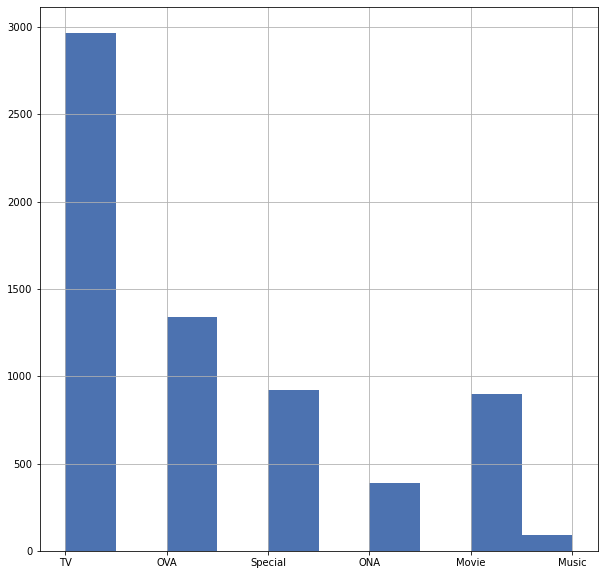

In [15]:
"""
    ** Exploring type**
    - TV 
    - OVA (Original Net Animation)
    - Special
    - OVA (Original Video Animation)
    - Movie
    - Music

"""
anime_list_scrubbed["type"].hist(figsize=(10,10))

<AxesSubplot:>

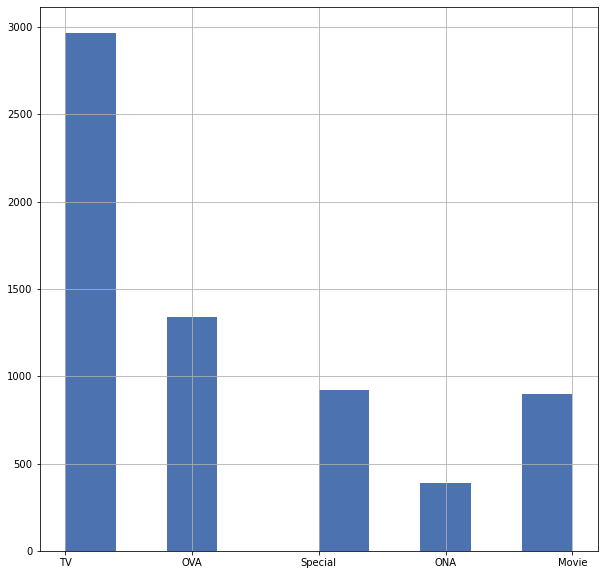

In [16]:
# Eliminate rows where the type is music, the goal is to recommend visual media
anime_list_scrubbed = anime_list_scrubbed[anime_list_scrubbed["type"] != "Music"]
anime_list_scrubbed["type"].hist(figsize=(10,10))

In [17]:
"""
    ** Exploring source **
    - Given that nearly 50% of all entries are some form of manga, eliminate source column
"""

anime_list_scrubbed.groupby(["source"]).count()

,anime_id,title,type,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,related,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
source,,,,,,,,,,,,,,,,,,,
4-koma manga,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193
Book,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
Card game,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
Digital manga,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Game,411,411,411,411,411,411,411,411,411,411,411,411,411,411,411,411,411,411,411
Light novel,511,511,511,511,511,511,511,511,511,511,511,511,511,511,511,511,511,511,511
Manga,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477,2477
Music,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
Novel,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280


In [18]:
anime_list_scrubbed.drop(["source"], axis=1, inplace=True)

In [19]:
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6667
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6511 non-null   int64  
 1   title            6511 non-null   object 
 2   type             6511 non-null   object 
 3   episodes         6511 non-null   int64  
 4   status           6511 non-null   object 
 5   airing           6511 non-null   bool   
 6   aired_string     6511 non-null   object 
 7   aired            6511 non-null   object 
 8   duration         6511 non-null   object 
 9   rating           6511 non-null   object 
 10  score            6511 non-null   float64
 11  scored_by        6511 non-null   int64  
 12  related          6511 non-null   object 
 13  studio           6511 non-null   object 
 14  genre            6511 non-null   object 
 15  opening_theme    6511 non-null   object 
 16  ending_theme     6511 non-null   object 
 17  duration_min  

In [20]:
"""
    ** Exploring episodes **

"""

anime_list_scrubbed.groupby("type")["episodes"].count()
                                     


type
Movie       900
ONA         388
OVA        1338
Special     919
TV         2966
Name: episodes, dtype: int64

In [21]:
anime_list_scrubbed.groupby("type").count()

,anime_id,title,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,related,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
type,,,,,,,,,,,,,,,,,,
Movie,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900
ONA,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388
OVA,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338
Special,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919
TV,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966


In [22]:
"""
    *** Side Note!!! ***
    - Converting type to integer here so hopefully a correlation graph can be done to see type and episodes
    
    0: TV
    1: OVA
    2: Special
    3: ONA
    4: Movie
"""


'\n    *** Side Note!!! ***\n    - Converting type to integer here so hopefully a correlation graph can be done to see type and episodes\n    \n    0: TV\n    1: OVA\n    2: Special\n    3: ONA\n    4: Movie\n'

In [23]:
anime_list_scrubbed["type"], unique = pd.factorize(anime_list_scrubbed["type"])
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6667
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6511 non-null   int64  
 1   title            6511 non-null   object 
 2   type             6511 non-null   int64  
 3   episodes         6511 non-null   int64  
 4   status           6511 non-null   object 
 5   airing           6511 non-null   bool   
 6   aired_string     6511 non-null   object 
 7   aired            6511 non-null   object 
 8   duration         6511 non-null   object 
 9   rating           6511 non-null   object 
 10  score            6511 non-null   float64
 11  scored_by        6511 non-null   int64  
 12  related          6511 non-null   object 
 13  studio           6511 non-null   object 
 14  genre            6511 non-null   object 
 15  opening_theme    6511 non-null   object 
 16  ending_theme     6511 non-null   object 
 17  duration_min  

In [24]:
anime_list_scrubbed.groupby("type").count()

,anime_id,title,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,related,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
type,,,,,,,,,,,,,,,,,,
0,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966,2966
1,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338
2,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919,919
3,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388
4,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900


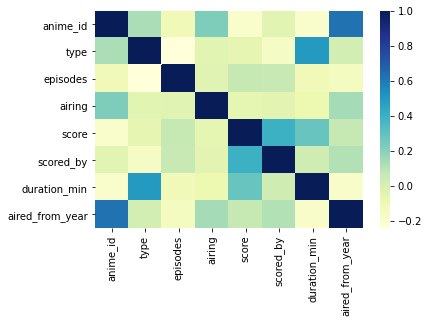

In [25]:
# Show correlation matrix with type included
anime_corr_map = sns.heatmap(anime_list_scrubbed.corr(),cmap="YlGnBu")
plt.show()

In [26]:
"""
    ** Status and Airing **
    - Status and Airing are essentially equivalent. Eliminate Status.
    - Over half are no longer airing, eliminate airing as well
"""
anime_list_scrubbed.drop(["status"], axis=1, inplace=True)
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6667
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6511 non-null   int64  
 1   title            6511 non-null   object 
 2   type             6511 non-null   int64  
 3   episodes         6511 non-null   int64  
 4   airing           6511 non-null   bool   
 5   aired_string     6511 non-null   object 
 6   aired            6511 non-null   object 
 7   duration         6511 non-null   object 
 8   rating           6511 non-null   object 
 9   score            6511 non-null   float64
 10  scored_by        6511 non-null   int64  
 11  related          6511 non-null   object 
 12  studio           6511 non-null   object 
 13  genre            6511 non-null   object 
 14  opening_theme    6511 non-null   object 
 15  ending_theme     6511 non-null   object 
 16  duration_min     6511 non-null   float64
 17  aired_from_yea

In [27]:
anime_list_scrubbed.groupby("airing").count()

,anime_id,title,type,episodes,aired_string,aired,duration,rating,score,scored_by,related,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
airing,,,,,,,,,,,,,,,,,
False,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337,6337
True,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174


In [28]:
anime_list_scrubbed.drop(["airing"], axis=1, inplace=True)
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6667
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6511 non-null   int64  
 1   title            6511 non-null   object 
 2   type             6511 non-null   int64  
 3   episodes         6511 non-null   int64  
 4   aired_string     6511 non-null   object 
 5   aired            6511 non-null   object 
 6   duration         6511 non-null   object 
 7   rating           6511 non-null   object 
 8   score            6511 non-null   float64
 9   scored_by        6511 non-null   int64  
 10  related          6511 non-null   object 
 11  studio           6511 non-null   object 
 12  genre            6511 non-null   object 
 13  opening_theme    6511 non-null   object 
 14  ending_theme     6511 non-null   object 
 15  duration_min     6511 non-null   float64
 16  aired_from_year  6511 non-null   int64  
dtypes: float64(2),

In [29]:
"""
    ** Eliminating more columns **
    - aired_string: should be irrelevant to getting a solid recommendation
    - aired: should be irrelevant to getting a solid recommendation
    - duration: provided lower down as duration_min using a float type
    - related: creating our own ratings, this column is unneeded
    - opening_theme: should be irrelevant since this is related to the anime's music
    - ending_theme: should be irrelevant since this is related to the anime's music
"""

anime_list_scrubbed.drop(["aired_string", "aired", "duration",
                          "related", "opening_theme", "ending_theme"], axis=1, inplace=True)
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6667
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6511 non-null   int64  
 1   title            6511 non-null   object 
 2   type             6511 non-null   int64  
 3   episodes         6511 non-null   int64  
 4   rating           6511 non-null   object 
 5   score            6511 non-null   float64
 6   scored_by        6511 non-null   int64  
 7   studio           6511 non-null   object 
 8   genre            6511 non-null   object 
 9   duration_min     6511 non-null   float64
 10  aired_from_year  6511 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 610.4+ KB


In [30]:
anime_list_scrubbed.groupby("rating").count()

,anime_id,title,type,episodes,score,scored_by,studio,genre,duration_min,aired_from_year
rating,,,,,,,,,,
G - All Ages,959,959,959,959,959,959,959,959,959,959
None,79,79,79,79,79,79,79,79,79,79
PG - Children,478,478,478,478,478,478,478,478,478,478
PG-13 - Teens 13 or older,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346
R - 17+ (violence & profanity),755,755,755,755,755,755,755,755,755,755
R+ - Mild Nudity,563,563,563,563,563,563,563,563,563,563
Rx - Hentai,331,331,331,331,331,331,331,331,331,331


In [31]:
"""
    ** Further processing of rating data **
    - Following the precedent set above, eliminate rated R anime
    - Eliminate anime with no rating
    - Factorize what's left:
        0: PG-13 - Teens 13 or older
        1: PG - Children
        2: G - All Ages
"""

anime_list_scrubbed = anime_list_scrubbed[anime_list_scrubbed["rating"] != "Rx - Hentai"]
anime_list_scrubbed = anime_list_scrubbed[anime_list_scrubbed["rating"] != "R+ - Mild Nudity"]
anime_list_scrubbed = anime_list_scrubbed[anime_list_scrubbed["rating"] != "R - 17+ (violence & profanity)"]
anime_list_scrubbed = anime_list_scrubbed[anime_list_scrubbed["rating"] != "None"]

In [32]:
anime_list_scrubbed.groupby("rating").count()

,anime_id,title,type,episodes,score,scored_by,studio,genre,duration_min,aired_from_year
rating,,,,,,,,,,
G - All Ages,959,959,959,959,959,959,959,959,959,959
PG - Children,478,478,478,478,478,478,478,478,478,478
PG-13 - Teens 13 or older,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346


In [33]:
anime_list_scrubbed["rating"], unique = pd.factorize(anime_list_scrubbed["rating"])
unique

Index(['PG-13 - Teens 13 or older', 'PG - Children', 'G - All Ages'], dtype='object')

In [34]:
anime_list_scrubbed.groupby("rating").count()

,anime_id,title,type,episodes,score,scored_by,studio,genre,duration_min,aired_from_year
rating,,,,,,,,,,
0,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346
1,478,478,478,478,478,478,478,478,478,478
2,959,959,959,959,959,959,959,959,959,959


In [35]:
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4783 entries, 0 to 6667
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         4783 non-null   int64  
 1   title            4783 non-null   object 
 2   type             4783 non-null   int64  
 3   episodes         4783 non-null   int64  
 4   rating           4783 non-null   int64  
 5   score            4783 non-null   float64
 6   scored_by        4783 non-null   int64  
 7   studio           4783 non-null   object 
 8   genre            4783 non-null   object 
 9   duration_min     4783 non-null   float64
 10  aired_from_year  4783 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 448.4+ KB


In [36]:
"""
    ** duration_min and aired_from_year **
"""

# Find the mean and standard deviation of duration_min
average = anime_list_scrubbed["duration_min"].mean()
standard_dev = anime_list_scrubbed["duration_min"].std()

# Print the mean and standard deviation
print(f"Mean: {average:.2f}")
print(f"Standard Deviation: {standard_dev:.2f}")

# Print outlier counts
print("Total titles below 3 standard deviations:")
print(anime_list_scrubbed[anime_list_scrubbed["duration_min"] < (average - (standard_dev * 3))]["anime_id"].count()) 
 
print("Total titles above 3 standard deviations:")                                                                                            
print(anime_list_scrubbed[anime_list_scrubbed["duration_min"] >= (average + (standard_dev * 3))]["anime_id"].count())


Mean: 28.07
Standard Deviation: 26.18
Total titles below 3 standard deviations:
0
Total titles above 3 standard deviations:
109


In [37]:
anime_list_scrubbed.groupby("type")["duration_min"].mean(), anime_list_scrubbed.groupby("type")["duration_min"].std()

(type
 0    20.527338
 1    28.882258
 2    19.074238
 3     8.246232
 4    70.342926
 Name: duration_min, dtype: float64,
 type
 0     7.426761
 1    14.753352
 2    22.394127
 3     9.176595
 4    36.563389
 Name: duration_min, dtype: float64)

In [38]:
anime_list_scrubbed.groupby("type")["duration_min"].max()

type
0     49.0
1    126.0
2    130.0
3     94.0
4    163.0
Name: duration_min, dtype: float64

In [39]:
print(f"0: {20.527338 + (7.426761 * 3)}")
print(f"1: {28.880452 + (14.765215 * 3)}")
print(f"2: {19.074238 + (22.394127 * 3)}")
print(f"3: {8.246232 + (9.176595 * 3)}")
print(f"4: {70.342926 + (36.563389 * 3)}")

0: 42.807621
1: 73.176097
2: 86.256619
3: 35.776017
4: 180.033093


In [40]:
# Eliminate duration, there are some significant outliers, so the model should not rely on it
# to make recommendations

anime_list_scrubbed.drop(["duration_min"], axis=1, inplace=True)

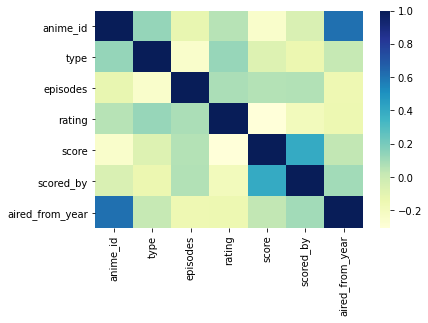

In [41]:
# Show correlation matrix
# Though there is a strong correlation between aired_from_year and type, for now it will stay
# Styles change over time so it's possible that an older style of drawing is more apppealing to
# a user.

anime_corr_map = sns.heatmap(anime_list_scrubbed.corr(),cmap="YlGnBu")
plt.show()

In [42]:
"""
    ** Exploring genre **
    - Split into multiple genres
    - Currently, not going to add a column for "primary genre" may revisit

"""
anime_list_scrubbed.groupby("genre").count()

,anime_id,title,type,episodes,rating,score,scored_by,studio,aired_from_year
genre,,,,,,,,,
Action,12,12,12,12,12,12,12,12,12
"Action, Adventure",1,1,1,1,1,1,1,1,1
"Action, Adventure, Cars, Comedy, Kids, Police",1,1,1,1,1,1,1,1,1
"Action, Adventure, Cars, Comedy, Sci-Fi, Shounen",1,1,1,1,1,1,1,1,1
"Action, Adventure, Cars, Sci-Fi",1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
"Supernatural, Magic",1,1,1,1,1,1,1,1,1
"Supernatural, Shounen",1,1,1,1,1,1,1,1,1
"Supernatural, Slice of Life",1,1,1,1,1,1,1,1,1


In [43]:
anime_list_scrubbed["genre"] = anime_list_scrubbed["genre"].str.replace('\, ', ",")
anime_list_scrubbed.groupby("genre").count()

,anime_id,title,type,episodes,rating,score,scored_by,studio,aired_from_year
genre,,,,,,,,,
Action,12,12,12,12,12,12,12,12,12
"Action,Adventure",1,1,1,1,1,1,1,1,1
"Action,Adventure,Cars,Comedy,Kids,Police",1,1,1,1,1,1,1,1,1
"Action,Adventure,Cars,Comedy,Sci-Fi,Shounen",1,1,1,1,1,1,1,1,1
"Action,Adventure,Cars,Sci-Fi",1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
"Supernatural,Magic",1,1,1,1,1,1,1,1,1
"Supernatural,Shounen",1,1,1,1,1,1,1,1,1
"Supernatural,Slice of Life",1,1,1,1,1,1,1,1,1


In [44]:
genre_dummies = anime_list_scrubbed["genre"].str.get_dummies(sep=",")
print(genre_dummies)


      Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  \
0          0          0     0       1         0       0      0      0   
1          0          0     0       1         0       0      0      0   
2          0          0     0       1         0       0      0      0   
3          0          0     0       1         0       0      1      0   
4          0          0     0       1         0       0      1      0   
...      ...        ...   ...     ...       ...     ...    ...    ...   
6660       0          0     0       0         0       0      0      0   
6662       0          0     0       0         0       0      0      0   
6665       0          0     0       0         0       0      0      0   
6666       0          0     0       0         0       0      0      0   
6667       0          0     0       0         0       0      0      0   

      Fantasy  Game  ...  Shounen  Shounen Ai  Slice of Life  Space  Sports  \
0           0     0  ...        1           

In [45]:
anime_list_scrubbed = pd.concat([anime_list_scrubbed, genre_dummies], axis=1)
anime_list_scrubbed.head(5)

,anime_id,title,type,episodes,rating,score,scored_by,studio,genre,aired_from_year,...,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,11013,Inu x Boku SS,0,12,0,7.63,139250,David Production,"Comedy,Supernatural,Romance,Shounen",2012,...,1,0,0,0,0,0,1,0,0,0
1,2104,Seto no Hanayome,0,26,0,7.89,91206,Gonzo,"Comedy,Parody,Romance,School,Shounen",2007,...,1,0,0,0,0,0,0,0,0,0
2,5262,Shugo Chara!! Doki,0,51,1,7.55,37129,Satelight,"Comedy,Magic,School,Shoujo",2008,...,0,0,0,0,0,0,0,0,0,0
3,721,Princess Tutu,0,38,0,8.21,36501,Hal Film Maker,"Comedy,Drama,Magic,Romance,Fantasy",2002,...,0,0,0,0,0,0,0,0,0,0
4,12365,Bakuman. 3rd Season,0,25,0,8.67,107767,J.C.Staff,"Comedy,Drama,Romance,Shounen",2012,...,1,0,0,0,0,0,0,0,0,0


In [46]:
# Eliminate original genre column
anime_list_scrubbed.drop(["genre"], axis=1, inplace=True)

In [47]:
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4783 entries, 0 to 6667
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         4783 non-null   int64  
 1   title            4783 non-null   object 
 2   type             4783 non-null   int64  
 3   episodes         4783 non-null   int64  
 4   rating           4783 non-null   int64  
 5   score            4783 non-null   float64
 6   scored_by        4783 non-null   int64  
 7   studio           4783 non-null   object 
 8   aired_from_year  4783 non-null   int64  
 9   Action           4783 non-null   int64  
 10  Adventure        4783 non-null   int64  
 11  Cars             4783 non-null   int64  
 12  Comedy           4783 non-null   int64  
 13  Dementia         4783 non-null   int64  
 14  Demons           4783 non-null   int64  
 15  Drama            4783 non-null   int64  
 16  Ecchi            4783 non-null   int64  
 17  Fantasy       

In [48]:
""" 
    Exploring Studio
    1) Break apart studio columns into individual studios
    2) Check for studio with most entries
    3) Make decision whether or not to keep these columns
    
"""

anime_list_scrubbed["studio"] = anime_list_scrubbed["studio"].str.replace('\, ', ",")
anime_list_scrubbed.groupby("studio").count()

,anime_id,title,type,episodes,rating,score,scored_by,aired_from_year,Action,Adventure,...,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
studio,,,,,,,,,,,,,,,,,,,,,
10Gauge,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2:10 Animation,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8bit,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
A-1 Pictures,124,124,124,124,124,124,124,124,124,124,...,124,124,124,124,124,124,124,124,124,124
"A-1 Pictures,Bridge",2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pH Studio,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"pH Studio,D &amp; D Pictures",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
production doA,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [49]:
dummies = anime_list_scrubbed["studio"].str.get_dummies(sep=",")
print(dummies)

      10Gauge  2:10 Animation  3xCube  8bit  A-1 Pictures  A-Real  A.C.G.T.  \
0           0               0       0     0             0       0         0   
1           0               0       0     0             0       0         0   
2           0               0       0     0             0       0         0   
3           0               0       0     0             0       0         0   
4           0               0       0     0             0       0         0   
...       ...             ...     ...   ...           ...     ...       ...   
6660        0               0       0     0             0       0         0   
6662        0               0       0     0             0       0         0   
6665        0               0       0     0             0       0         0   
6666        0               0       0     0             0       0         0   
6667        0               0       0     0             0       0         0   

      ACC Production  AIC  AIC A.S.T.A.  ...  domer

In [50]:
list_studios = dummies.columns.values.tolist()
list_studios

['10Gauge',
 '2:10 Animation',
 '3xCube',
 '8bit',
 'A-1 Pictures',
 'A-Real',
 'A.C.G.T.',
 'ACC Production',
 'AIC',
 'AIC A.S.T.A.',
 'AIC Build',
 'AIC Classic',
 'AIC Plus+',
 'AIC Spirits',
 'AIC Takarazuka',
 'APPP',
 'AXsiZ',
 'Actas',
 'Agent 21',
 'Ajia-Do',
 'Amuse',
 'Animaruya',
 'Animate Film',
 'Animation Do',
 'Annapuru',
 'Anpro',
 'Arms',
 'Artland',
 'Artmic',
 'Asahi Production',
 'Ascension',
 'Ashi Production',
 'Asread',
 'Asura Film',
 'Azeta Pictures',
 'B&amp;T',
 'Bandai Namco Pictures',
 'Barnum Studio',
 'Bee Train',
 'Beijing Huihuang Animation Company',
 'Beijing Rocen Digital',
 'Big Bang',
 'Blade',
 'Bones',
 'Bouncy',
 'Boyan Pictures',
 'Brain&#039;s Base',
 'Bridge',
 'Buemon',
 'C-Station',
 'C2C',
 'CG Year',
 'Calf Studio',
 'Chaos Project',
 'Charaction',
 'ChuChu',
 'CloverWorks',
 'CoMix Wave Films',
 'Coastline Animation Studio',
 'Connect',
 'Cookie Jar Entertainment',
 'Craftar',
 'Creators Dot Com',
 'Creators in Pack',
 'D &amp; D Picture

In [51]:
# Total all shows by studio and find the maximum number and minimum
studio_totals = dummies.sum(axis=0)
studio_totals.max(), studio_totals.min()

(374, 1)

<AxesSubplot:>

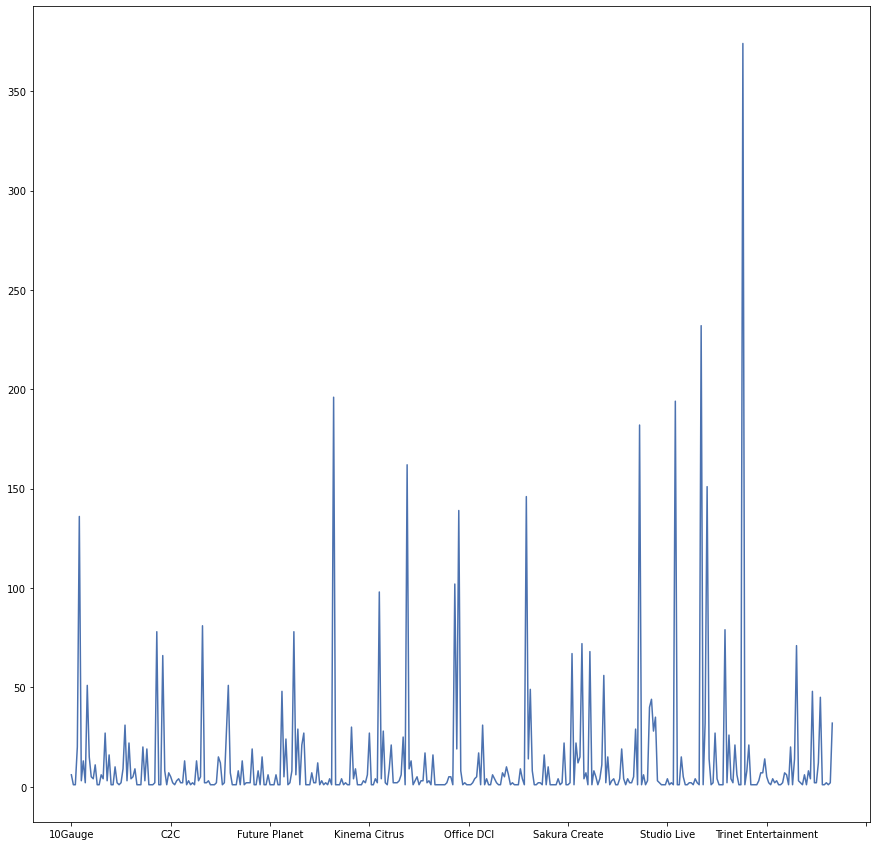

In [52]:
studio_totals.plot(figsize=(15,15))

In [53]:
studio_totals.mean()

13.401041666666666

In [54]:
studio_totals.std()

34.6967556885217

In [55]:
# Find the mean and standard deviation of duration_min
average = studio_totals.mean()
standard_dev = studio_totals.std()

# Print the mean and standard deviation
print(f"Mean: {average:.2f}")
print(f"Standard Deviation: {standard_dev:.2f}")

# Titles below mean
print("Total titles below mean:")
print(studio_totals[studio_totals < (average)].count()) 

# Print outlier counts
print("Total titles outliers:")
print(studio_totals[studio_totals < (average - (standard_dev * 3))].count()) 
 
print("Total titles above 3 standard deviations:")                                                                                            
print(studio_totals[studio_totals >= (average + (standard_dev * 3))].count())


Mean: 13.40
Standard Deviation: 34.70
Total titles below mean:
307
Total titles outliers:
0
Total titles above 3 standard deviations:
10


In [56]:
# Because the average is less than 1 standard deviation, 82% of titles fall below the mean. rendering this information 
# invalid. 
# Studio column will be dropped

anime_list_scrubbed.drop(["studio"], axis=1, inplace=True)

In [57]:
anime_list_scrubbed.sort_values(by=["title"], inplace=True)
anime_list_scrubbed.to_csv("MyAnimeList Dataset/anime_list_scrubbed.csv", index=False)
anime_list_scrubbed = pd.read_csv("MyAnimeList Dataset/anime_list_scrubbed.csv")
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783 entries, 0 to 4782
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         4783 non-null   int64  
 1   title            4783 non-null   object 
 2   type             4783 non-null   int64  
 3   episodes         4783 non-null   int64  
 4   rating           4783 non-null   int64  
 5   score            4783 non-null   float64
 6   scored_by        4783 non-null   int64  
 7   aired_from_year  4783 non-null   int64  
 8   Action           4783 non-null   int64  
 9   Adventure        4783 non-null   int64  
 10  Cars             4783 non-null   int64  
 11  Comedy           4783 non-null   int64  
 12  Dementia         4783 non-null   int64  
 13  Demons           4783 non-null   int64  
 14  Drama            4783 non-null   int64  
 15  Ecchi            4783 non-null   int64  
 16  Fantasy          4783 non-null   int64  
 17  Game          

In [58]:

# Drop anime_id: it has been used for counting up until this point, however due to the
# unique indexes, and the similarity to aired_from_year, it is unnecessary
anime_list_scrubbed.drop(["anime_id"], axis=1, inplace=True)
anime_list_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783 entries, 0 to 4782
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4783 non-null   object 
 1   type             4783 non-null   int64  
 2   episodes         4783 non-null   int64  
 3   rating           4783 non-null   int64  
 4   score            4783 non-null   float64
 5   scored_by        4783 non-null   int64  
 6   aired_from_year  4783 non-null   int64  
 7   Action           4783 non-null   int64  
 8   Adventure        4783 non-null   int64  
 9   Cars             4783 non-null   int64  
 10  Comedy           4783 non-null   int64  
 11  Dementia         4783 non-null   int64  
 12  Demons           4783 non-null   int64  
 13  Drama            4783 non-null   int64  
 14  Ecchi            4783 non-null   int64  
 15  Fantasy          4783 non-null   int64  
 16  Game             4783 non-null   int64  
 17  Harem         

In [59]:
"""
    ** Final preparations for the model **
    - Turn the title into integer data via OneHotEncoder
"""
categorical_features = ["title"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                  one_hot,
                                  categorical_features)],
                               remainder="passthrough")

transformed_anime_list = transformer.fit_transform(anime_list_scrubbed)

In [60]:
# Normalize the data

max_abs_scaler = MaxAbsScaler()
transformed_anime_list = max_abs_scaler.fit_transform(transformed_anime_list)

In [61]:
# Create KNN Model
np.random.seed(42)
knn = NearestNeighbors(n_neighbors=6,
    algorithm='auto',
).fit(transformed_anime_list)

In [62]:
# Test the model
distance, index = knn.kneighbors(transformed_anime_list[411])
distance, index

(array([[0.        , 1.57345006, 1.74481339, 1.74781447, 1.80072681,
         1.80973217]]),
 array([[ 411,  418, 2980, 2981, 2983, 2982]], dtype=int64))

In [63]:
pickle.dump(knn, open("movie_info_model.pkl", "wb"))

In [64]:
anime_list = pd.read_csv("MyAnimeList Dataset/anime_list_scrubbed.csv")
# Accuracy will be determined by how much the distance deviates from the shortest possible
# distance
def accuracy(x, min_val):
   return (1 - (abs(x - min_val)/min_val)) * 100 

# Calculate the distances between 6 neighbors for all elements
distances = knn.kneighbors_graph(transformed_anime_list, n_neighbors=6, mode='distance')
distances.toarray()

# Drop values where the distance is 0 (The element matched to itself) 
distance_values = distances[distances > 0]

# Calculate the shortest distance to any element
min_val = np.min(distance_values)

# Determine average accuracy and worst accuracy
distance_average = np.mean(distance_values)
distance_max_val = np.max(distance_values)

print("Average Accuracy: ", accuracy(distance_average, min_val))
print("Worst Accuracy: ", accuracy(distance_max_val, min_val))

print(anime_list_scrubbed.iloc[411].loc["title"], "Accuracy List")
for x in range(1,6):
    print(anime_list_scrubbed.iloc[index[0,x]].loc["title"],"Accuracy:", accuracy(distance[0,x], min_val), "%")


Average Accuracy:  83.85143990693798
Worst Accuracy:  -24.527702165217203
Bleach Accuracy List
Bleach: The Sealed Sword Frenzy Accuracy: 88.74027919422706 %
Noragami Accuracy: 76.62306210739469 %
Noragami Aragoto Accuracy: 76.41085376380256 %
Noragami OVA Accuracy: 72.66938619093608 %
Noragami Aragoto OVA Accuracy: 72.03261111654174 %
